# DATA CHALLENGE - MS BGD 2020-2021 - Julien Maksoud

# Résumé de la méthode & Commentaire général

- A la lecture du sujet, j'ai interprété pendant longtemps le sujet comme un problème de détection d'anomalies en supervisé. 



- J'ai testé de très nombreux algorithmes en passant à chaque fois du temps à investiguer les différents paramètres.


- En testant tous les algorithmes que j'ai trouvé (listés plus bas), je n'ai jamais dépassé 0.80 avec le jeu de données de base. Cela veut dire qu'il y a un problème de biais qui ne peut être résolu qu'en ajoutant du pouvoir explicatif, donc en ajoutant des features qui permettent de débiaiser le modèle.


- En investiguant, je me suis aperçu qu'il y avait des doublons dans le xtrain. Et que le pourcentage d'anomalies était beaucoup plus élevé dans les doublons.


- La première idée a donc été de créer une colonne 'Doublon' qui prend les valeurs suivantes
    - 1 si la ligne est dupliquée
    - 0 si elle n'est pas dupliquée
    
    
- La deuxième idée a été de merger xtrain et xtest et de constater qu'il y avait des duplicats entre les deux datasets. 
J'ai donc créé une deuxième feature de duplicat inter xtrain/xtest pour mettre en exergue les duplicats entre xtrain et xtest. 




# Key takeaway:

- Etant donné que les anomalies ne sont pas des outliers (au sens valeurs extrêmes dans les distributions), j'ai fini par comprendre que ce problème se résume à de la classification de classes déséquilibrées, ce qui permet de cibler les bons algorithmes.


- Enrichir avec des algos de type IsolationForest n'a pas été utile. Je ne suis pas certain que l'auto-encodeur aurait pu marcher également, car la feature à créer n'était pas dépendante des valeurs des données, mais du fait qu'elle était dupliquée ou non. 


- Quand on ne dépasse pas 0.80 avec de nombreux algorithmes, alors on a un problème de biais. Il devient inutile de chercher "le bon algo qui va résoudre le problème" Ce problème de biais ne peut être résolu qu'en ajoutant des features pertinentes. Ces features sont données par les experts métier et nécessitent de savoir "sortir la tête des chiffres" et prendre du recul.


- Le fait de pouvoir définir des poids a permis de calculer des loss qui prenaient en compte les déséquilibres de proportion des classes. Les méthodes d'oversampling et d'undersampling n'ont pas été efficaces.


- Pour un problème de classification, calculer le ROC AUC feature par feature est un bon moyen de savoir si - pour un algorithme donné - la feature va être utile. 


- Les features les plus utiles ne seront pas toujours les mêmes selon les algorithmes utilisés. Le test du ROC AUC feature par feature devrait être refait à chaque fois qu'on teste un nouvel algorithme.


- De manière générale, les hyperparamètres par défaut des librairies de calcul sont bien choisis. A l'exception des NN, changer les paramètres ne va pas faire de vraie grosse différence. Donc, quand on teste des modèles, il ne faut pas s'attendre à bondir de 20% en ajustant les paramètres.


- Quand on fait un GridSearch, il faut faire attention à ne pas mettre de paramètres qui vont générer un surapprentissage ou trop lisser les données en les moyennant. Le risque est de trouver un minimum local avec des paramètres aberrants.

Par exemple, sur une RandomForest : Il est inutile de mettre un max_depth > 10 car on est dans le surapprentissage au delà. 


##### La compréhension des données est essentielle. Si l'on avait su dés le départ qu'une pièce anomalique pouvait être ré-usinée, la présence de doublons et le fait qu'il y a beaucoup d'anomalies parmis eux aurait été beaucoup plus simple à déceler. 

##### On l'entend souvent, mais on a pu en faire l'expérience: Les compréhensions du métier et du process qui a généré les données sont fondamentales.



# Investigation des données
    
## Histogramme des samples anomaliques VS samples non-anomaliques: 
On voit que les samples anomaliques sont dans les mêmes ranges que les samples non-anomaliques. 
Les méthodes de recherches d'outliers ne sont pas - à priori - utiles pour régler ce problème.


## Recherche de redondances entre différentes features. 
Avec une matrice de corrélation, on voit que certaines features étaient très fortement corrélées. 

D'autres étaient tout simplement dupliquées (corrélées à 1)


## Comment trouver les features utiles ? 

##### Méthode 1: Pour un algorithme donné, calcul des ROC AUC Feature par Feature

- Etape 1: J'ai calculé les ROC AUC de chaque feature afin de mesurer son pouvoir prédictif. Les scores allaient de 0.47 à 0.76 pour un Decision Tree. Certaines features avaient un ROC AUC = 0.5 , et pouvaient donc être enlevées du modèle. 


- Etape 2: J'ai essayé de prendre un modèle de base et coder un "pseudo-RFE-Forward" (car n'ayant pas vu que RFE existait...). L'idée était la suivante: Commencer par prendre la feature qui donnait le meilleur ROC AUC. Puis ajouter la deuxième meilleure et voir si les deux features donnent un meilleur ROC_AUC. 

##### Méthode 2: S'apercevoir (un peu trop tard) qu'il existe déjà des méthodes précodées dans scikit-learn telles que le RFE.
Elle permet de sélectionner le nombre de features qu'on va retenir.
Par contre, je n'ai pas trouvé le moyen d'optimiser le nombre de features à sélectionner pour maximiser le ROC_AUC. 
Il aurait donc fallu prendre les 27 features, prendre à chaque fois les k premières features, et voir pour quel nombre de features k on allait maximiser le ROC_AUC. 


## Tentatives de réduction de dimension

- PCA: Il n'était pas possible de distinguer les groupes anomaliques des non-anomaliques avec une PCA.

- Auto Encodeurs: Je n'ai pas réussi non plus à obtenir des résultats significatifs. Mais je manque d'expérience sur le sujet. 





# Tentatives d'enrichissement du training set

- AutoEncodeurs: 
J'ai essayé de créer des features avec plus de pouvoir explicatif à partir des features d'origines, mais cela n'a pas marché (je n'ai pas encore assez de recul sur les auto-encodeurs)


- IsolationForest: 
L'idée était d'essayer de faire un clustering et essayer de voir si on pouvait identifier un groupe contenant une proportion significative d'anomalies. Mais sans succès également.





# Key-Point: Existence d'observations doublons


Etant donné qu'il y avait des doublons dans les features (corrélations à 1), le même travail a été fait pour les échantillons. A la base, je pensais que les corrélations à 1 avaient été ajoutées artificiellement. J'ai donc pensé que les duplicats avaient été ajoutés pour nous mettre sur une fausse piste. 


J'ai ensuite testé beaucoup d'algorithmes pour me retrouver 


C'est la que ça s'est révélé intéressant. J'ai regardé les duplicats. Puis ai remarqué la moyenne de Y était très élevée par rapport à l'ensemble du dataset. J'ai donc déduit que l'existance d'un doublon pouvait caractériser l'anomalie.



# Interprétation de l'existance de doublons

L'interprétation logique voudrait que - quand une pièce a été usinée défaillante - il a fallu en ré-usiner une autre.
La première pièce était donc défaillante, la deuxième ne l'était pas. 


# Key-Point 2: Existence de doublons entre Train et Test

Supposons que les données train aient été générées avant celles de test. 

S'il y a des problèmes d'usinages pour une pièce aux caractéristiques particulières pendant la phase de train, on peut s'attendre à ce que cette pièce pose encore problème plus tard. Les pièces qui sont déjà sorties cassées ont des chances de ressortir cassées une prochaine fois. 

D'où l'idée de tester également la présence de doublons entre le xtrain et le xtest. Cette stratégie a donné lieu à une deuxième colonne de feature augmentation qui répond à la question "Si on merge xtrain et xtest, est-ce qu'on va retrouver d'autres doublons entre ces deux datasets?"




# Modèle final 

- Le modèle final aura été un Neural Network Fully Connected. Les paramètres sont les suivants

    - Dropout = 0.2 à chaque couche
    - Nombre de neurones dans chaque couche cachée = 3 fois le nombre de features
    - 2 couches cachées
    - Optimisation de type Adam avec un LR initial de 0.005 . Le Decay et le Momentum ont été laissés par défaut. 
    - La Loss utilisée a été la Binary Cross Entropy
    - Poids inversement proportionnels aux nombre d'observations (1 pour classe 0 et 38.18 pour classe 1)


Commentaire: Le problème étant un problème de biais, plusieurs modèles donnaient un score tout aussi satisfaisant. J'ai choisi un réseau de neurones, mais d'autres tels que le XGBoost marchaient tout aussi bien.




# Comment aurait-on pu encore améliorer le score

Si on suppose que les données tests ont été générées APRES les données train, alors il aurait fallu rechercher si un doublon existe dans le train et prédire la même chose que dans Ytrain. 


# CHARGEMENT DES LIBRAIRIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from scipy.stats import binom
from sklearn.utils import shuffle


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


from sklearn.model_selection import train_test_split

import time

import warnings
warnings.filterwarnings("ignore")

# CHARGEMENT DES DONNEES

In [2]:
xtrain = pd.read_csv("valeo_xtrain.csv")
ytrain = pd.read_csv("valeo_ytrain.csv")
xtest = pd.read_csv("valeo_xtest.csv")

# VISUALISATION DES DONNEES

### Display des éléments anomaliques dans le dataset

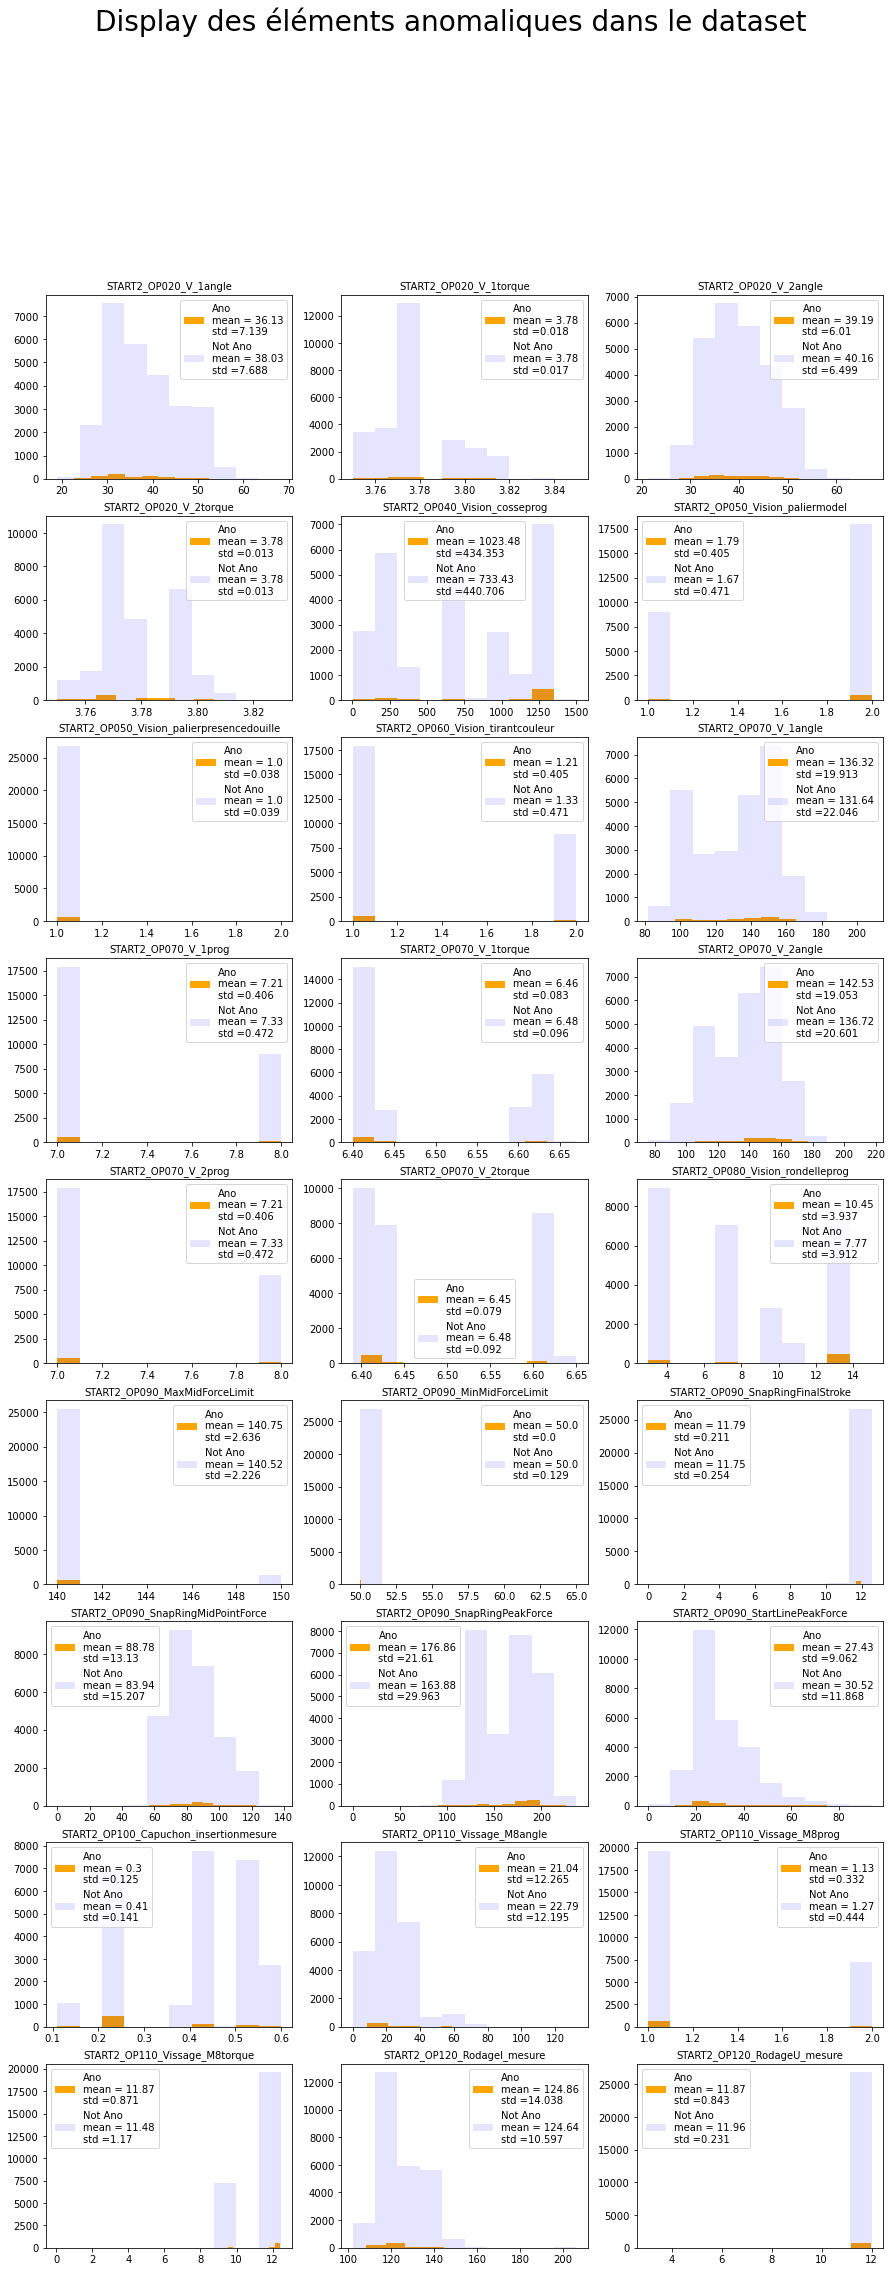

In [3]:
index_ano = xtrain[ytrain['Anomaly']==1].index
xtrain_ano = xtrain[xtrain.index.isin(index_ano)]


index_not_ano = xtrain[ytrain['Anomaly']==0].index
xtrain_not_ano = xtrain[xtrain.index.isin(index_not_ano)]



fig = plt.figure(figsize=(15,40))
plt.suptitle("Display des éléments anomaliques dans le dataset",size=28)


for i in range(len(xtrain_ano.columns)):
    fig.add_subplot(len(xtrain_ano.columns)//3+1, 3 , i+1)
    plt.hist(xtrain_ano.iloc[:,i],color='orange',alpha=1,label=f"Ano\nmean = {round(xtrain_ano.iloc[:,i].mean(),2)}\nstd ={round(xtrain_ano.iloc[:,i].std(),3)}")
    plt.hist(xtrain_not_ano.iloc[:,i],color='blue',alpha=0.1,label=f"Not Ano\nmean = {round(xtrain_not_ano.iloc[:,i].mean(),2)}\nstd ={round(xtrain_not_ano.iloc[:,i].std(),3)}")
    plt.title(f"{xtrain.columns[i]}",size=10)
    plt.legend()

plt.show()

# Recherche de corrélation dans les features

Text(0.5, 1.0, 'Correlation between different features')

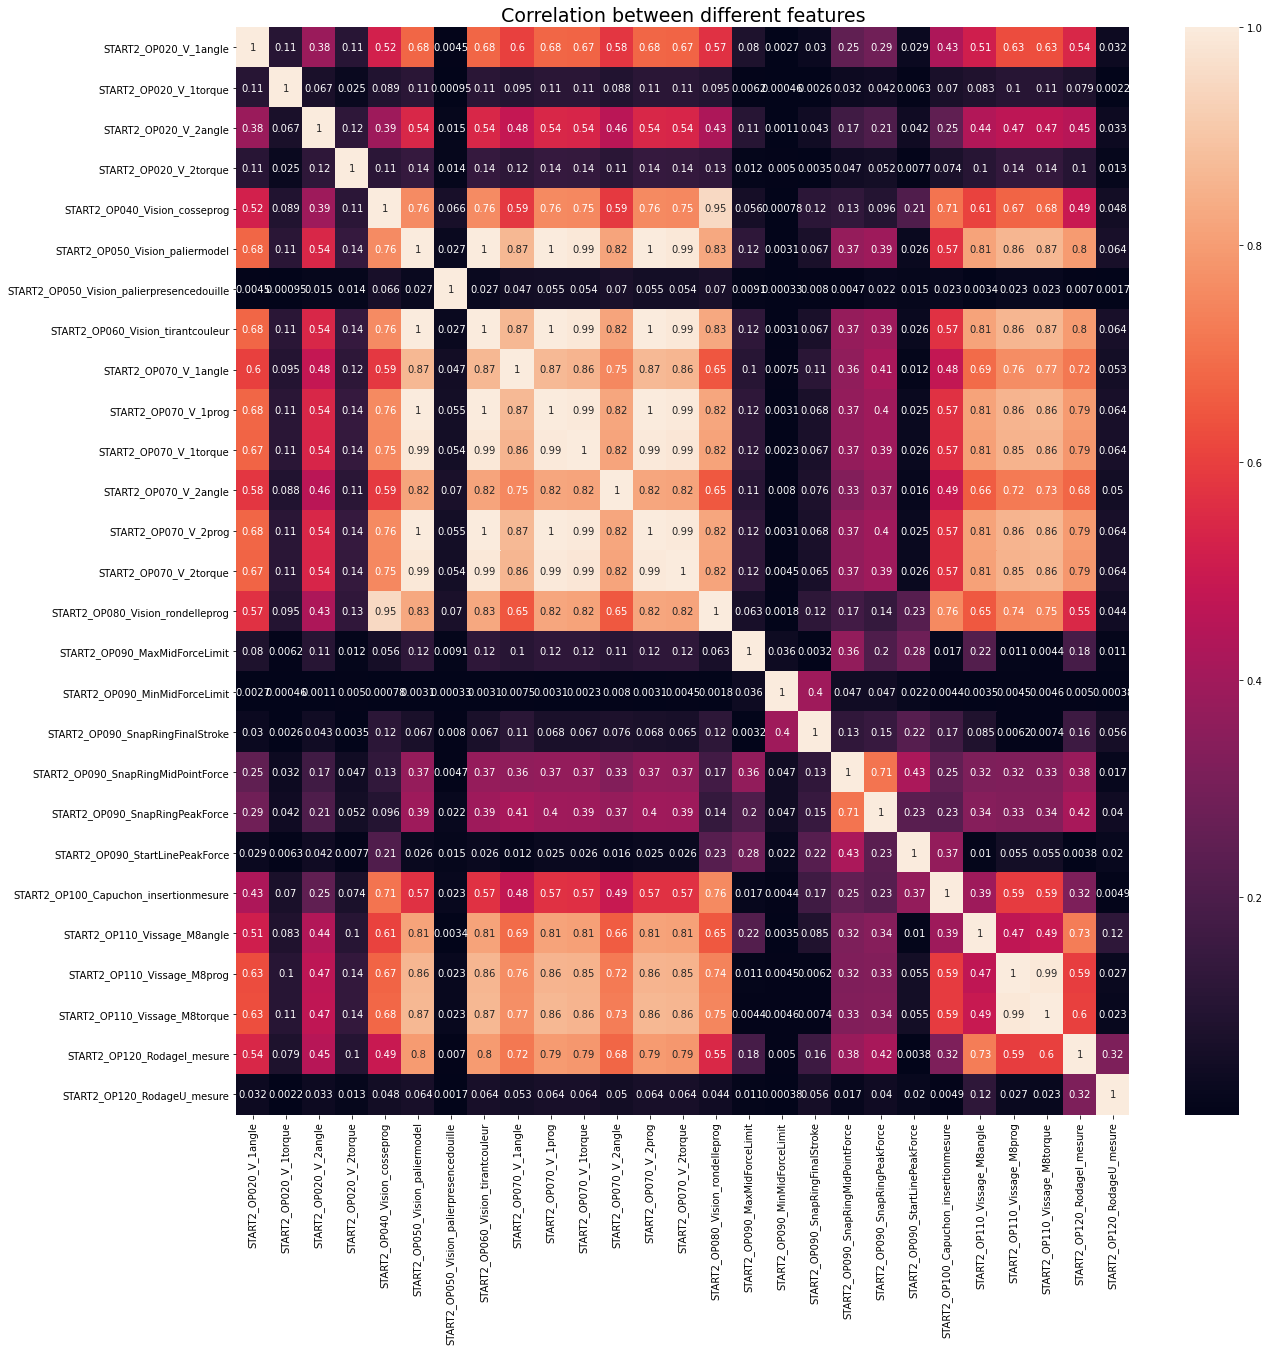

In [4]:
tmp = pd.DataFrame(xtrain)
corr_matrix = tmp.corr().abs()

plt.figure(figsize = (20,20))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation between different features',size=19)

# MISE EN EXERGUE DE LA PROPORTION ELEVEE D'ANOMALIE DANS LES DOUBLONS

In [5]:
index_doublons = xtrain[xtrain.duplicated(keep=False)==True].index
print(f"Proportion d'anomalies parmis les doublons = {round(100*ytrain.loc[index_doublons,'Anomaly'].mean(),2)}%")

Proportion d'anomalies parmis les doublons = 49.39%


# CREATION DES FONCTIONS POUR ENRICHISSEMENT ET TEST DES MODELES

### FONCTION DE CREATION DES SETS D'ENTRAINEMENT ET DE VALIDATION

In [6]:
def standardization_and_split(dfx,dfy,prop_train=0.85):

    scal = StandardScaler()
    dfx = pd.DataFrame(scal.fit_transform(dfx))
    Xtrain,Xtest,Ytrain,Ytest = train_test_split(dfx,dfy,train_size=prop_train, random_state=52, shuffle=True,stratify=ytrain)

    return Xtrain,Xtest,Ytrain,Ytest

### FONCTION DE TEST DES ALGORITHMES DE SCIKIT-LEARN

In [7]:

from sklearn.base import is_classifier
import sklearn.ensemble
import sklearn.linear_model
import sklearn.tree
import sklearn.neural_network
import sklearn.svm
import sklearn.neighbors
import sklearn.gaussian_process
import sklearn.neural_network
import sklearn.semi_supervised
import sklearn.discriminant_analysis


def testingalgos(Xtr,Ytr,Xte,Yte):

    """ La fonction sklearn.base.is_classifier(estimator) permet de lister facilement toutes les librairies 
    de classification. 
    On importe tous les paquets, puis on les teste tous afin d'obtenir les scores correspondants. Ensuite,
    on met les noms d'algos et les ROC AUC scores dans un dataframe qui nous aidera à déterminer facilement 
    le meilleur algo"""

    roc_auc_scores = []
    model_names = []

    # liste de tous les packages de sklearn
    for package in [sklearn.ensemble,sklearn.linear_model,sklearn.tree,sklearn.neural_network,sklearn.svm,
                   sklearn.neighbors,sklearn.gaussian_process,sklearn.neural_network,sklearn.semi_supervised,
                   sklearn.discriminant_analysis]:
                
        for modelname in package.__all__:        # On liste tous les modèles de tous les packages
            try:
                model = getattr(package, modelname)()  # Récupère le nom du package
                if is_classifier(model)==True:         # Si l'algo est un classifieur, on essaie de fitter et prédire avec
#                     print(modelname,' is a classifier')
                    try:
                        model = getattr(package, modelname)()  # Récupérer le nom de l'algorithme
                        try: 
                            model.set_params(n_jobs=-1)        # Si possible, utiliser tous les CPU
#                             print(f'n_jobs=-1 for {model}')
                        except:
                            print(f'impossible to set n_jobs=-1 for {model}')
#                               continue
                              
                        model.fit(Xtr,Ytr)              
#                         print('fit complete')
                        pred=model.predict_proba(Xte)
#                         print('predict complete')

                        roc_auc_scores.append(roc_auc_score(Yte,pred[:,1]))  # calcul du ROC AUC et nom pour le modèle  
                        model_names.append(modelname)                        # et ajout dans liste
                        print(f'{modelname} has a ROC AUC score of {roc_auc_score(Yte,pred[:,1])}') # créer un dataframe
                        del model
                        del pred
#                         print('model and pred deleted')
                    except:
#                         continue 
                        print('Process could not complete for ' , modelname)
            except:
                print('Process could not complete for ' , modelname)
#             continue 
                
    output = pd.DataFrame({'Model': model_names,'ROC_AUC': roc_auc_scores})  
    
    return output                                                            # retourner le dataframe


### FONCTION D'AJOUT DE COLONNE A PARTIR DE PRESENCE DE DUPLICAT

In [8]:
def add_duplicate_col(df):
    
    """ Cette fonction va regarder dans un dataset si un doublon existe et ajouter une colonne.
    Si le doublon existe, la nouvelle colonne prend pour valeur 1
    Si le doublon n'existe pas, la nouvelle colonne prend pour valeur 0"""

    duplicateornot = df.duplicated(keep=False)
    duplicateornot[duplicateornot==False]=0
    duplicateornot[duplicateornot==True]=1
    duplicateornot = pd.DataFrame(duplicateornot)
    output = pd.concat([df,duplicateornot],axis=1)
    return output

# ENRICHISSEMENT ET CALCUL DES SCORES

## ETAPE 1 : SCORES SANS FEATURE AUGMENTATION

In [9]:
# rechargement des fichiers
xtrain = pd.read_csv("valeo_xtrain.csv")
ytrain = pd.read_csv("valeo_ytrain.csv")

a=time.time()

# standardisation et split en train/validation
Xtrain,Xtest,Ytrain,Ytest = standardization_and_split(xtrain,ytrain)

# test et génération d'un tableau modèles vs scores
scores_classif_data_non_enrichies = testingalgos(Xtr=Xtrain,Ytr=Ytrain,Xte=Xtest,Yte=Ytest)

b=time.time()
print(f"Process terminé en {round(b-a,3)} secondes")

Process could not complete for  BaseEnsemble
RandomForestClassifier has a ROC AUC score of 0.7292520784867091
ExtraTreesClassifier has a ROC AUC score of 0.5516248903550589
BaggingClassifier has a ROC AUC score of 0.622468632012509
impossible to set n_jobs=-1 for GradientBoostingClassifier()
GradientBoostingClassifier has a ROC AUC score of 0.8349533770641852
impossible to set n_jobs=-1 for AdaBoostClassifier()
AdaBoostClassifier has a ROC AUC score of 0.8061119903893825
Process could not complete for  VotingClassifier
Process could not complete for  VotingRegressor
Process could not complete for  StackingClassifier
Process could not complete for  StackingRegressor
Process could not complete for  Huber
LogisticRegression has a ROC AUC score of 0.7916769955379276
LogisticRegressionCV has a ROC AUC score of 0.7750109644941078
Process could not complete for  PassiveAggressiveClassifier
Process could not complete for  Perceptron
impossible to set n_jobs=-1 for RidgeClassifier()
Process cou

In [21]:
print(f"Sans Feature Augmentation, xtrain possède {len(pd.read_csv('valeo_xtrain.csv').T)} features")

Sans Feature Augmentation, xtrain possède 27 features


In [29]:
scores_classif_data_non_enrichies

,Model,ROC_AUC
0,RandomForestClassifier,0.729252
1,ExtraTreesClassifier,0.551625
2,BaggingClassifier,0.622469
3,GradientBoostingClassifier,0.834953
4,AdaBoostClassifier,0.806112
5,LogisticRegression,0.791677
6,LogisticRegressionCV,0.775011
7,DecisionTreeClassifier,0.509257
8,ExtraTreeClassifier,0.510483
9,MLPClassifier,0.806048


## ETAPE 2 : SCORES AVEC AJOUT DE COLONNE DUPLICATS AU SEIN DE XTRAIN

In [10]:
a=time.time()

# rechargement des fichiers
xtrain = pd.read_csv("valeo_xtrain.csv")
ytrain = pd.read_csv("valeo_ytrain.csv")
xtest = pd.read_csv("valeo_xtest.csv")

# augmentation de feature basée sur présence de duplicat
xtrain = add_duplicate_col(xtrain)
xtest = add_duplicate_col(xtest) 

# standardisation et split en train/validation
Xtrain,Xtest,Ytrain,Ytest = standardization_and_split(xtrain,ytrain)

# test et génération d'un tableau modèles vs scores
scores_classif_data_enrichie_1col= testingalgos(Xtr=Xtrain,Ytr=Ytrain,Xte=Xtest,Yte=Ytest)

b=time.time()
print(f"Process terminé en {round(b-a,3)} secondes")

Process could not complete for  BaseEnsemble
RandomForestClassifier has a ROC AUC score of 0.8859382746653446
ExtraTreesClassifier has a ROC AUC score of 0.6040280214332024
BaggingClassifier has a ROC AUC score of 0.7948161778726973
impossible to set n_jobs=-1 for GradientBoostingClassifier()
GradientBoostingClassifier has a ROC AUC score of 0.9027377865069982
impossible to set n_jobs=-1 for AdaBoostClassifier()
AdaBoostClassifier has a ROC AUC score of 0.8913668910415316
Process could not complete for  VotingClassifier
Process could not complete for  VotingRegressor
Process could not complete for  StackingClassifier
Process could not complete for  StackingRegressor
Process could not complete for  Huber
LogisticRegression has a ROC AUC score of 0.8925860951146027
LogisticRegressionCV has a ROC AUC score of 0.8526443499485146
Process could not complete for  PassiveAggressiveClassifier
Process could not complete for  Perceptron
impossible to set n_jobs=-1 for RidgeClassifier()
Process co

In [28]:
print("Le dataset possède maintenant 28 colonnes")
scores_classif_data_enrichie_1col

Le dataset possède maintenant 28 colonnes


,Model,ROC_AUC
0,RandomForestClassifier,0.885938
1,ExtraTreesClassifier,0.604028
2,BaggingClassifier,0.794816
3,GradientBoostingClassifier,0.902738
4,AdaBoostClassifier,0.891367
5,LogisticRegression,0.892586
6,LogisticRegressionCV,0.852644
7,DecisionTreeClassifier,0.551545
8,ExtraTreeClassifier,0.548072
9,MLPClassifier,0.859385


## ETAPE 3 : SCORES AVEC AJOUT DE DEUX COLONNES:
###  - DUPLICATS AU SEIN DE XTRAIN 
###  - DUPLICATS ENTRE XTRAIN ET XTEST

In [11]:
a=time.time()

# On créé un merge entre train et test
xtrainxtest = pd.concat([xtrain,xtest])

# On ajoute une colonne "est-ce que duplicat existe entre train et test"
xtrainxtest = add_duplicate_col(xtrainxtest)

# On resépare xtrain et xtest
xtrain = xtrainxtest[:27586]
xtest = xtrainxtest[27586:]

# on standardise et splitte 
Xtrain,Xtest,Ytrain,Ytest = standardization_and_split(xtrain,ytrain)

# Calcul des scores pour différents algos
scores_classif_data_enrichie_2cols = testingalgos(Xtr=Xtrain,Ytr=Ytrain,Xte=Xtest,Yte=Ytest)

b=time.time()
print(f"Process terminé en {round(b-a,3)} secondes")

Process could not complete for  BaseEnsemble
RandomForestClassifier has a ROC AUC score of 0.979115022310362
ExtraTreesClassifier has a ROC AUC score of 0.7872602112810343
BaggingClassifier has a ROC AUC score of 0.9470450688379543
impossible to set n_jobs=-1 for GradientBoostingClassifier()
GradientBoostingClassifier has a ROC AUC score of 0.9838655085618397
impossible to set n_jobs=-1 for AdaBoostClassifier()
AdaBoostClassifier has a ROC AUC score of 0.9792842568933298
Process could not complete for  VotingClassifier
Process could not complete for  VotingRegressor
Process could not complete for  StackingClassifier
Process could not complete for  StackingRegressor
Process could not complete for  Huber
LogisticRegression has a ROC AUC score of 0.9863158346363602
LogisticRegressionCV has a ROC AUC score of 0.9867377293009421
Process could not complete for  PassiveAggressiveClassifier
Process could not complete for  Perceptron
impossible to set n_jobs=-1 for RidgeClassifier()
Process cou

In [32]:
print(f"xtrain possède maintenant {len(xtrain.T)} features")
print(f"Les modèles vont maintenant ")
scores_classif_data_enrichie_2cols

xtrain possède maintenant 29 features


,Model,ROC_AUC
0,RandomForestClassifier,0.979115
1,ExtraTreesClassifier,0.787260
2,BaggingClassifier,0.947045
3,GradientBoostingClassifier,0.983866
4,AdaBoostClassifier,0.979284
5,LogisticRegression,0.986316
6,LogisticRegressionCV,0.986738
7,DecisionTreeClassifier,0.668144
8,ExtraTreeClassifier,0.643398
9,MLPClassifier,0.984366


# DISTRIBUTION DES ANOMALIES SUR LES NOUVELLES FEATURES CREEES

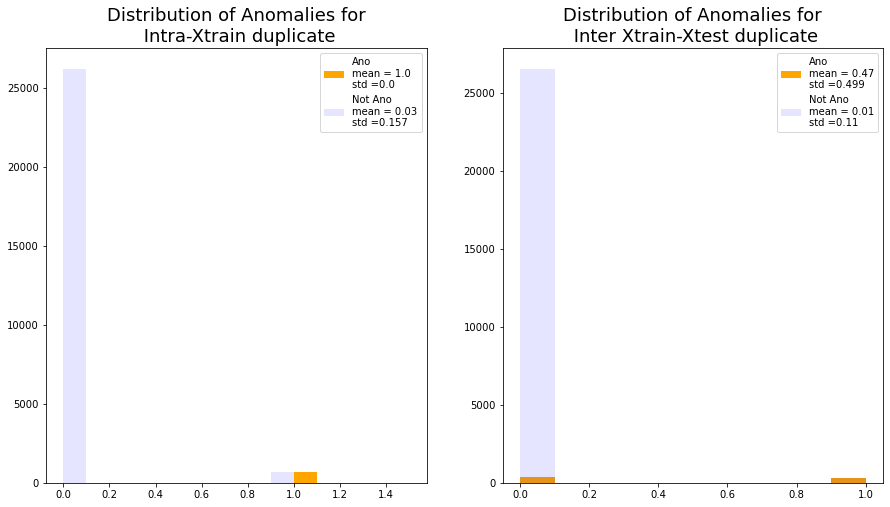

In [13]:
index_ano = xtrain[ytrain['Anomaly']==1].index
xtrain_ano = xtrain[xtrain.index.isin(index_ano)]


index_not_ano = xtrain[ytrain['Anomaly']==0].index
xtrain_not_ano = xtrain[xtrain.index.isin(index_not_ano)]


fig = plt.figure(figsize=(15,8))
fig.add_subplot(1,2,1)
plt.hist(xtrain_ano.iloc[:,28],color='orange',alpha=1,label=f"Ano\nmean = {round(xtrain_ano.iloc[:,28].mean(),2)}\nstd ={round(xtrain_ano.iloc[:,28].std(),3)}")
plt.hist(xtrain_not_ano.iloc[:,28],color='blue',alpha=0.1,label=f"Not Ano\nmean = {round(xtrain_not_ano.iloc[:,28].mean(),2)}\nstd ={round(xtrain_not_ano.iloc[:,28].std(),3)}")
plt.title(f"Distribution of Anomalies for\n Intra-Xtrain duplicate",size=18)
plt.legend()


fig.add_subplot(1,2,2)
plt.hist(xtrain_ano.iloc[:,27],color='orange',alpha=1,label=f"Ano\nmean = {round(xtrain_ano.iloc[:,27].mean(),2)}\nstd ={round(xtrain_ano.iloc[:,27].std(),3)}")
plt.hist(xtrain_not_ano.iloc[:,27],color='blue',alpha=0.1,label=f"Not Ano\nmean = {round(xtrain_not_ano.iloc[:,27].mean(),2)}\nstd ={round(xtrain_not_ano.iloc[:,27].std(),3)}")
plt.title(f"Distribution of Anomalies for\n Inter Xtrain-Xtest duplicate",size=18)


plt.legend()

plt.show()

# APPORT DES COLONNES DE DUPLICATS EN FONCTION DES ALGORITHMES

Avec une stack bar, on peut voir - pour chacune des méthodes - caractériser l'augmentation de ROC_AUC en fonction de la feature ajoutée. 

Text(0.5, 1.0, "Evolution des ROC AUC en fonction de la Feature Augmentation\nAucun tuning n'a été fait sur les algorithmes")

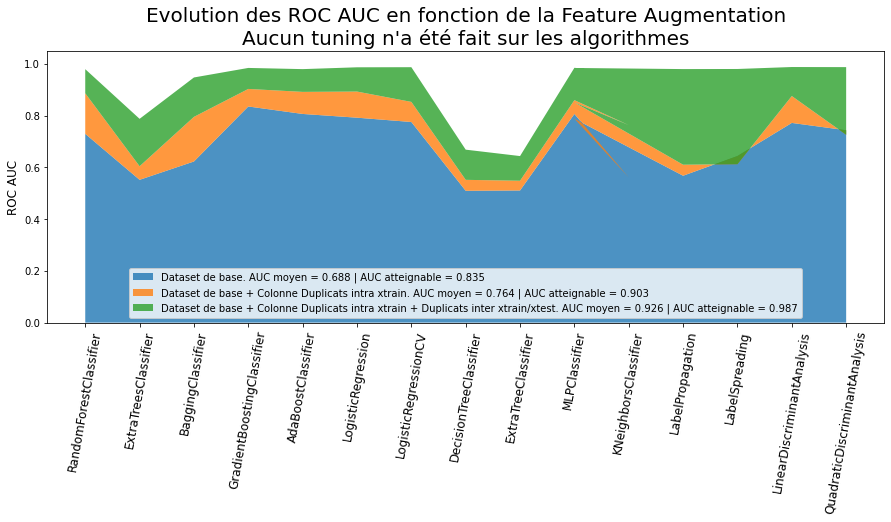

In [12]:

import numpy as np
import matplotlib.pyplot as plt

# Create data
x=scores_classif_data_non_enrichies['Model']
y1=scores_classif_data_non_enrichies['ROC_AUC']
y2=scores_classif_data_enrichie_1col['ROC_AUC']
y3=scores_classif_data_enrichie_2cols['ROC_AUC']

plt.figure(figsize=(15,5))
# Basic stacked area chart.
# plt.stackplot(x,y1, y2, y3, labels=['A','B','C'])
plt.stackplot(x,y1,y2-y1,y3-y2,alpha=0.8,
               labels=[f"Dataset de base. AUC moyen = {round(y1.mean(),3)} | AUC atteignable = {round(y1.max(),3)}",
                       f"Dataset de base + Colonne Duplicats intra xtrain. AUC moyen = {round(y2.mean(),3)} | AUC atteignable = {round(y2.max(),3)}",
                       f"Dataset de base + Colonne Duplicats intra xtrain + Duplicats inter xtrain/xtest. AUC moyen = {round(y3.mean(),3)} | AUC atteignable = {round(y3.max(),3)}"])
plt.legend(loc=8)
plt.xticks(rotation=80,size=12)
plt.ylabel("ROC AUC",size=12)
plt.ylim(0,1.05)
plt.title("Evolution des ROC AUC en fonction de la Feature Augmentation\nAucun tuning n'a été fait sur les algorithmes", size=20)

## Les nouvelles featues isolent bien les anomalies par rapport aux non-anomalies

# MODELE CHOISI

A partir du moment où l'on a compris qu'il fallait faire du feature engineering, on peut ensuite choisir parmis les algorithmes ayant donné les meilleurs scores. 

Dans mon cas, je choisis le MLP avec Keras car j'arrive à le faire tourner en GPU et je l'ai trouvé simple d'utilisation.

On pourra m'opposer le manque d'explicabilité des réseaux de neurones, mais dans mon cas c'est celui qui m'a donné les meilleurs résultats. D'autres algorithmes comme le RandomForest ou la Logistic Regression ont tout aussi bien marché et sont plus simples à expliquer.

In [14]:
# On change le type des inputs pour les rendre Keras-compatibles

Xtrain = Xtrain.astype(np.float32)
Ytrain = Ytrain.astype(np.float32)
Xtest =  Xtest.astype(np.float32)
Ytest = Ytest.astype(np.float32)

In [15]:
from tensorflow import keras


# Définition de l'architecture du réseau

neurones_nb = 3*xtrain.shape[-1]                       

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(xtrain.shape[-1],)
        ),
        keras.layers.Dense(neurones_nb, activation="relu"),     # neurones_nb neurones dans couche cachée
        keras.layers.Dropout(0.2),                              # 20% des neurones sont remis à 0 à chaque itération
        keras.layers.Dense(neurones_nb, activation="relu"),     # neurones_nb neurones dans couche cachée
        keras.layers.Dropout(0.2),                              # 20% des neurones sont remis à 0 à chaque itération
        keras.layers.Dense(1, activation="sigmoid"),            # 1 neurone en sortie car classif binaire
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7680      
_________________________________________________________________
dense_1 (Dense)              (None, 87)                22359     
_________________________________________________________________
dropout (Dropout)            (None, 87)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 87)                7656      
_________________________________________________________________
dropout_1 (Dropout)          (None, 87)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 88        
Total params: 37,783
Trainable params: 37,783
Non-trainable params: 0
____________________________________________________

In [16]:
# Définition des hyperparamètres

metrics = keras.metrics.AUC(name="AUC")  # Metrics utilisé par le NN pour suivre le process d'optim

    # Tentative d'utiliser la SigmoidFocalCrossEntropy qui allait se focaliser sur les classes positives
    # mais n'a pas fait mieux que la Binary Cross Entropy
# loss_custom = tfa.losses.SigmoidFocalCrossEntropy(
#     from_logits = False,
#     alpha = 0.05,
#     gamma = 1.0,
#     name = 'sigmoid_focal_crossentropy'
# )


# Définition d'une Loss binaire cross entropy "classique" pour ce problème de classification

loss_binary = keras.losses.BinaryCrossentropy(from_logits=True, 
                                              label_smoothing=0, 
                                              reduction="auto", 
                                              name="binary_crossentropy")

# Optimiseur: On choisit un optimiseur de type Adam avec les paramètres de Decay et Momentum par défaut. 
model.compile(optimizer=keras.optimizers.Adam(5e-2), loss=loss_binary, metrics=metrics)

# Conditions d'arrêt du réseau de neurones avant la fin du nombre d'epochs
callbacks = keras.callbacks.EarlyStopping( 
    monitor="val_loss",      # il vérifie la loss de validation
    min_delta=0,             # différence minimale de loss validation entre 2 itérations
    patience=3,              # si la loss remonte 3 itérations de suite, le NN s'arrête 
    verbose=0,               # quantité de commentaires donnés par keras pendant le process
    mode="auto",
    baseline=None,                 
    restore_best_weights=False)


weight_for_0 = 1 / len(Ytrain[Ytrain['Anomaly']==0]) # Poids des samples non-anomaliques
weight_for_1 = 1 / len(Ytrain[Ytrain['Anomaly']==1]) # Poids des samples non-anomaliques

class_weight = {0: weight_for_0, 1: weight_for_1} # Class weights utilisés pour calculer la Loss

model.fit(
    Xtrain,                               # 
    Ytrain,                               # 
    batch_size=1000,                      # Nombre de samples par batch
    epochs=30,                            # 30 itérations au total 
    verbose=2,
    callbacks=callbacks,                  # Définition des early stoppings définis au dessus
    validation_data=(Xtest, Ytest),       # Définition des validation data pour savoir si NN continue ou s'arrête
    class_weight=class_weight,            # poids des classes pour la définition de la Loss
    
)


Epoch 1/30
24/24 - 4s - loss: 1.1485e-05 - AUC: 0.9858 - val_loss: 0.1654 - val_AUC: 0.9871
Epoch 2/30
24/24 - 0s - loss: 7.1674e-06 - AUC: 0.9867 - val_loss: 0.0889 - val_AUC: 0.9836
Epoch 3/30
24/24 - 0s - loss: 7.0647e-06 - AUC: 0.9858 - val_loss: 0.1425 - val_AUC: 0.9868
Epoch 4/30
24/24 - 0s - loss: 6.9685e-06 - AUC: 0.9862 - val_loss: 0.1084 - val_AUC: 0.9838
Epoch 5/30
24/24 - 0s - loss: 6.9737e-06 - AUC: 0.9868 - val_loss: 0.0872 - val_AUC: 0.9835
Epoch 6/30
24/24 - 0s - loss: 6.9751e-06 - AUC: 0.9868 - val_loss: 0.1191 - val_AUC: 0.9866
Epoch 7/30
24/24 - 0s - loss: 5.6628e-06 - AUC: 0.9873 - val_loss: 0.0876 - val_AUC: 0.9858
Epoch 8/30
24/24 - 0s - loss: 9.2968e-06 - AUC: 0.9869 - val_loss: 0.0838 - val_AUC: 0.9874
Epoch 9/30
24/24 - 0s - loss: 7.1454e-06 - AUC: 0.9852 - val_loss: 0.0780 - val_AUC: 0.9839
Epoch 10/30
24/24 - 0s - loss: 6.5715e-06 - AUC: 0.9852 - val_loss: 0.0802 - val_AUC: 0.9850
Epoch 11/30
24/24 - 0s - loss: 6.1028e-06 - AUC: 0.9872 - val_loss: 0.0884 - va

In [17]:
print(f"Avec ce réseau de Neurones, le ROC AUC = {roc_auc_score(Ytest,model.predict_proba(Xtest))} sur le validation set")

Avec ce réseau de Neurones, le ROC AUC = 0.9874504214179474 sur le validation set


In [18]:
np.savetxt('ytest_challenge_student.csv', pd.DataFrame(model.predict_proba(Xtest)), fmt = '%1.6f', delimiter=',')